In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle,bz2
import pandas as pd
import extinction
import corner
import copy
import emcee
import time

from scipy.io import readsav
from scipy.stats import norm

from sim_utils.GeneralRandom import GeneralRandom
from sim_utils.getmags import get_absolute_mags,get_observable_mags,get_noisy_mags
from sim_utils.oneCMD import oneCMD

from analysis.PPP_loglik import loglik,GKDE_lik,set_GR,logpost

%matplotlib notebook

In [2]:
root = '/user/gennaro/ABC_synth/WORK/hercules/'

with bz2.BZ2File(root+'catalog.pbz2', 'rb') as f:
    catd = pickle.load(f)

dat_mag1 = catd['dat_mag1']
dat_mag2 = catd['dat_mag2']
dat_det  = catd['dat_det']

with bz2.BZ2File(root+'iso_int.pbz2', 'rb') as f:
    iso_int = pickle.load(f)

with bz2.BZ2File(root+'ASKDtree.pbz2', 'rb') as f:
    ASKDtree = pickle.load(f)

with bz2.BZ2File(root+'AScat.pbz2', 'rb') as f:
    AScat = pickle.load(f)

AS_mag1_in  = AScat['AS_mag1_in']
AS_mag2_in  = AScat['AS_mag2_in']
AS_mag1_out = AScat['AS_mag1_out']
AS_mag2_out = AScat['AS_mag2_out']
AS_det      = AScat['AS_det']


In [3]:
DM = 20.64
Av = 0.279

ext1 = Av*(extinction.ccm89(np.array([5921.1]),1,3.1))[0]
ext2 = Av*(extinction.ccm89(np.array([8057.0]),1,3.1))[0]

In [4]:
# Setup the random numbers generators


isoPD = pickle.load(open( '/user/gennaro/UFDs_OPT/shelves/isoACS.pickle', "rb" ) )
age_vals = isoPD['age_vals']
feh_vals = isoPD['feh_vals']
del(isoPD)

limits_all = [(np.log(0.4),np.log(5)),
              (np.amin(age_vals),np.amax(age_vals)),
              (np.amin(feh_vals),np.amax(feh_vals)),
              (20.64-1,20.64+1),
              (-1,1.),
              (0,1.),
              (0,1.)]

#Age
sfh = pd.read_table('/user/gennaro/UFDs_OPT/herc/hercsfh.txt',header=None,sep='\s+',
                   names=['age','feh','weights'])
ages_sfh = np.unique(sfh.age.values)
marg_wgt = np.zeros_like(ages_sfh)
for i,aaa in enumerate(ages_sfh):
    marg_wgt[i] = np.sum(sfh[sfh.age == aaa].weights.values)
    
pal = np.linspace(limits_all[1][0],limits_all[1][1],250)
pav = np.zeros_like(pal)
for i,aaa in enumerate(ages_sfh):
    pav = pav + marg_wgt[i]*norm.pdf(pal,loc=aaa,scale=0.1)
age_GR = GeneralRandom(pal,pav,1000)
    
#Metallicity
dicMDF = readsav('/user/gennaro/UFDs_OPT/MDFS/Summary_grid0p2_herc_adp.sav')
pfl = feh_vals
pfv = dicMDF.mednmdf
feh_GR = GeneralRandom(pfl,pfv,1000)

#DM
DMT_GR = DM


#A_606 - A_814
ex1_GR = ext1

#A_814
ex2_GR = ext2

GRdic = {'logM':np.nan,
         'Age':age_GR,
         'FeH':feh_GR,
         'DM':DM,
         'BinQ':np.nan,
         'Alam1':ex1_GR,
         'Alam2':ex2_GR
        }

In [5]:
# Setup the priors on alpha and binary fraction

hpal = np.array([-3,-1.])
hpav = np.array([1.,1])
hpa_GR = GeneralRandom(hpal,hpav,500)

hpbl = np.array([0.,1.])
hpbv = np.array([1.,1])
hpb_GR = GeneralRandom(hpbl,hpbv,500)

In [6]:
#Define the dictionary of all parameters

dictopass ={'GRdic':GRdic,
            'iso_int':iso_int,
            'ASKDtree':ASKDtree,
            'AS_mag1_in':AS_mag1_in,
            'AS_mag2_in':AS_mag2_in,
            'AS_mag1_out':AS_mag1_out,
            'AS_mag2_out':AS_mag2_out,
            'AS_det':AS_det,
            'data':[],
            'bwcol':0.02,
            'bwmag':0.05,
            'hp_alpha': hpa_GR,
            'hp_bf':hpb_GR
            }


Time elapsed 1.5825719833374023


<IPython.core.display.Javascript object>


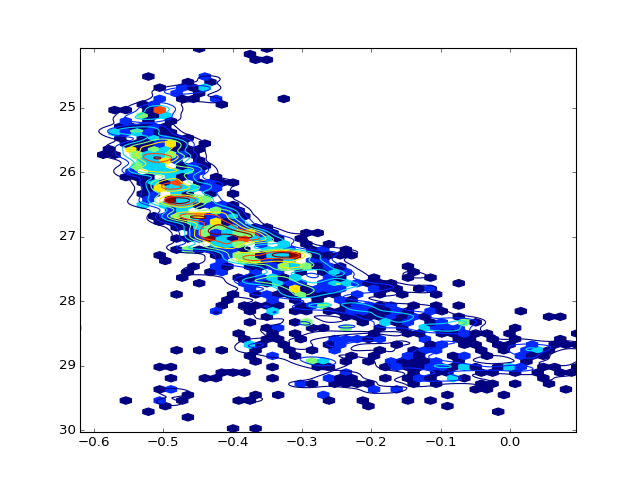

In [7]:
#Simulate a reference CMD to be used as "Data"

nsimdata = 1000
mss_GR_h, bin_GR_h = set_GR(-1.5,0.3)

kwargs = copy.deepcopy(dictopass)

GRdic_h = kwargs['GRdic']
GRdic_h['logM'] = mss_GR_h
GRdic_h['BinQ'] = bin_GR_h

t0  = time.time()

pars, absmags, obsmags, simdata, ntrue, indGR = oneCMD(1000,GRdic_h,
                                                             kwargs['iso_int'],kwargs['ASKDtree'],kwargs['AS_mag1_in'],kwargs['AS_mag2_in'],
                                                             kwargs['AS_mag1_out'],kwargs['AS_mag2_out'],kwargs['AS_det'])

print('Time elapsed',time.time()-t0)

dictopass['data'] = simdata


plt.close("all")
plt.hexbin(simdata[:,0]-simdata[:,1],simdata[:,1],mincnt=1)
plt.ylim(31,18)

colgrid1 = np.arange(-.8, .5, 0.005)
maggrid1 = np.arange(20, 30, 0.005)
colgrid, maggrid = np.meshgrid(colgrid1, maggrid1)
ncol = colgrid1.size
nmag = maggrid1.size
exponents = np.zeros([nmag,ncol,nsimdata])
    
for i in range(nmag):
    for j in range(ncol):
        dx2 = ((simdata[:,0]-simdata[:,1]-colgrid[i,j])/kwargs['bwcol'])**2
        dy2 = ((simdata[:,1]-maggrid[i,j])/kwargs['bwmag'])**2
        exponents[i,j,:] =  -0.5*(dx2+dy2)

exponentials = np.exp(exponents)
indlnlik = (np.sum(exponentials,axis=2))
plt.contour(colgrid,maggrid,indlnlik)


In [8]:
#Initialize and run emcee

ndim, nwalkers = 3, 30

pn = np.random.poisson(lam=dictopass['data'].size/2,size=nwalkers)
pa = np.random.uniform(low=-3,high=-1,size=nwalkers)
pb = np.random.uniform(low=0,high=1,size=nwalkers)


p0 = np.array([pn,pa,pb]).T
tt = time.time()    
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, kwargs=dictopass)

nsteps = 100

for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    if (i % (nsteps/10) == 0):
        print(100.*(1.*i)/nsteps,' % done')
        
print('Total time',time.time()-tt)


0.0  % done
10.0  % done
20.0  % done
30.0  % done
40.0  % done
50.0  % done
60.0  % done
70.0  % done
80.0  % done
90.0  % done
Total time 5780.131336450577


In [1]:
corner.corner(sampler.flatchain)

NameError: name 'corner' is not defined

In [2]:
sampler.naccepted

NameError: name 'sampler' is not defined